In [415]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal, RealAmplitudes
from qiskit_aer import Aer
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import plot_histogram

import tensorflow as tf
import copy
import matplotlib.pyplot as plt
import time

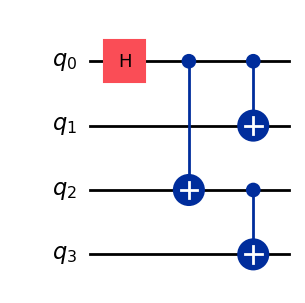

In [416]:
# Create real data generator
def generate_ghz(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.h(0)
 
    l = int(np.ceil(np.log2(num_qubits)))
    for m in range(l, 0, -1):
        for k in range(0, num_qubits, 2 ** m):
            if k + 2 ** (m - 1) >= num_qubits: continue
            qc.cx(k, k + 2 ** (m - 1))
    return qc

REAL_DIST_NQUBITS = 4
real_circuit = generate_ghz(REAL_DIST_NQUBITS)
real_circuit.draw('mpl')

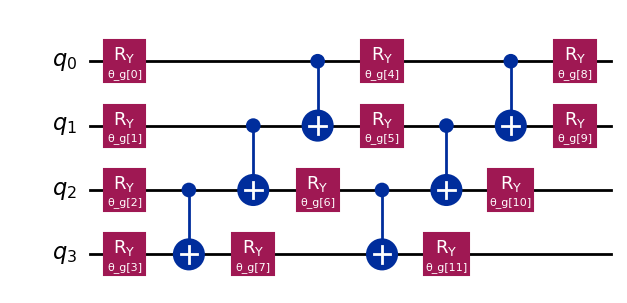

In [417]:
# Create generator

# generator = TwoLocal(REAL_DIST_NQUBITS,
#                      # Parameterized single qubit rotations
#                      ['ry', 'rz'],
#                      'cz',  # Entangling gate
#                      'full', # Entanglement structure: all to all
#                      reps=2, # Number of layers
#                      parameter_prefix='θ_g',
#                      name='Generator')

generator = RealAmplitudes(REAL_DIST_NQUBITS,
                     reps=2, # Number of layers
                     parameter_prefix='θ_g',
                     name='Generator')
generator = generator.decompose() # decompose into standard gates
generator.draw('mpl')

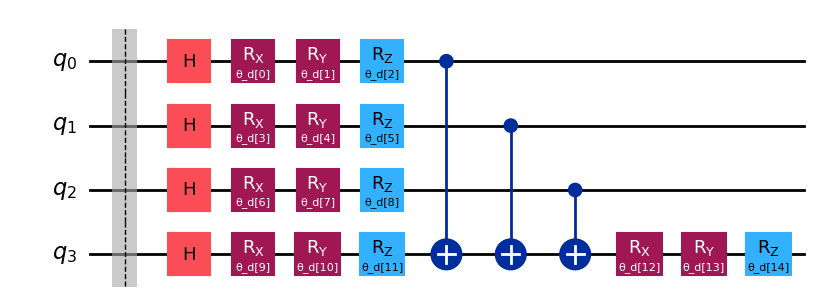

In [418]:
# Create discriminator
def generate_discriminator(num_qubits, disc_weights):
    qc = QuantumCircuit(num_qubits, name="Discriminator")
    param_index = 0

    qc.barrier()

    #for?
    # qc.h(0)

    for q in range(num_qubits):
        qc.h(q)
        qc.rx(disc_weights[param_index], q); param_index += 1
        qc.ry(disc_weights[param_index], q); param_index += 1
        qc.rz(disc_weights[param_index], q); param_index += 1
    
    for i in range(num_qubits - 1):
        qc.cx(i, num_qubits - 1)
    # l = int(np.ceil(np.log2(num_qubits)))
    # for m in range(1, l+1):
    #     print("m:", m)
    #     for k in range(1, num_qubits, 2 ** m):
    #         print("k:", k)
    #         if k + 2 ** (m - 1) >= num_qubits: continue
    #         qc.cx(k, k + 2 ** (m - 1))

    qc.rx(disc_weights[param_index], num_qubits-1); param_index += 1
    qc.ry(disc_weights[param_index], num_qubits-1); param_index += 1
    qc.rz(disc_weights[param_index], num_qubits-1); param_index += 1
    
    #qc.measure(num_qubits-1, 0) # For real hardware execution
    return qc
disc_weights = ParameterVector('θ_d', 3*(REAL_DIST_NQUBITS+1))
discriminator = generate_discriminator(REAL_DIST_NQUBITS, disc_weights)
discriminator.draw('mpl')

In [419]:
# Parameters
N_GPARAMS = generator.num_parameters
N_DPARAMS = discriminator.num_parameters
N_GPARAMS, N_DPARAMS

(12, 15)

In [420]:
# Connect real data and discriminator
real_disc_circuit = QuantumCircuit(REAL_DIST_NQUBITS)
real_disc_circuit.compose(real_circuit, inplace=True)
real_disc_circuit.compose(discriminator, inplace=True)

In [421]:
# Connect generator and discriminator
gen_disc_circuit = QuantumCircuit(REAL_DIST_NQUBITS)
gen_disc_circuit.compose(generator, inplace=True)
gen_disc_circuit.compose(discriminator, inplace=True)

In [422]:
# Cost calculation functions
# We'll use Statevector to retrieve statevector of given circuit

def generator_cost(gen_params):
    curr_params = np.append(disc_params.numpy(),
                            gen_params.numpy())
    state_probs = Statevector(gen_disc_circuit
                              .assign_parameters(curr_params)
                             ).probabilities()
    
    prob_fake_true = np.sum(state_probs[2**(REAL_DIST_NQUBITS-1):]) #CAMBIA
    cost = -prob_fake_true
    return cost

def discriminator_cost(disc_params):
    curr_params = np.append(disc_params.numpy(),
                            gen_params.numpy())
    gendisc_probs = Statevector(gen_disc_circuit
                                .assign_parameters(curr_params)
                               ).probabilities()
    realdisc_probs = Statevector(real_disc_circuit.
                                 assign_parameters(disc_params.numpy())
                                ).probabilities()
    # Get total prob of measuring |1> on last qubit
    prob_fake_true = np.sum(gendisc_probs[2**(REAL_DIST_NQUBITS-1):])
    # Get total prob of measuring |1> on q2
    prob_real_true = np.sum(realdisc_probs[2**(REAL_DIST_NQUBITS-1):])
    cost = prob_fake_true - prob_real_true
    return cost

In [423]:
def calculate_kl_div(model_distribution: dict, target_distribution: dict):
    """Gauge model performance using Kullback Leibler Divergence"""
    kl_div = 0
    for bitstring, p_data in target_distribution.items():
        if np.isclose(p_data, 0, atol=1e-8):
            continue
        if bitstring in model_distribution.keys():
            kl_div += (p_data * np.log(p_data)
                 - p_data * np.log(model_distribution[bitstring]))
        else:
            kl_div += p_data * np.log(p_data) - p_data * np.log(1e-6)
    return kl_div

In [424]:
from qiskit_aer import Aer
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_ibm_runtime import SamplerV2 as Sampler
#downgrade to qiskit 1.x so is compatible with qiskit-machien-learning 0.8.2

backend = Aer.get_backend('aer_simulator_statevector')

# define quantum instances (statevector and sample based)
sampler = Sampler(mode=backend)

# specify QNN to update generator weights
gen_qnn = SamplerQNN(circuit=gen_disc_circuit,  # parameterized circuit
                     # frozen input arguements (discriminator weights)
                     input_params=gen_disc_circuit.parameters[:N_DPARAMS],
                     # differentiable weights (generator weights)
                     weight_params=gen_disc_circuit.parameters[N_DPARAMS:],
                     sparse=True, # returns sparse probability vector
                     sampler=sampler)

# specify QNNs to update discriminator weights
disc_fake_qnn = SamplerQNN(circuit=gen_disc_circuit, # parameterized circuit
                           # frozen input arguments (generator weights)
                           input_params=gen_disc_circuit.parameters[N_DPARAMS:],
                           # differentiable weights (discrim. weights)
                           weight_params=gen_disc_circuit.parameters[:N_DPARAMS],
                           sparse=True, # get sparse probability vector
                           sampler=sampler)

disc_real_qnn = SamplerQNN(circuit=real_disc_circuit, # parameterized circuit
                           input_params=[], # no input parameters
                           # differentiable weights (discrim. weights)
                           weight_params=gen_disc_circuit.parameters[:N_DPARAMS],
                           sparse=True, # get sparse probability vector
                           sampler=sampler)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


In [425]:
# Initialize parameters
init_gen_params = np.random.uniform(low=-np.pi,
                                    high=np.pi,
                                    size=(N_GPARAMS,))
init_disc_params = np.random.uniform(low=-np.pi,
                                     high=np.pi,
                                     size=(N_DPARAMS,))

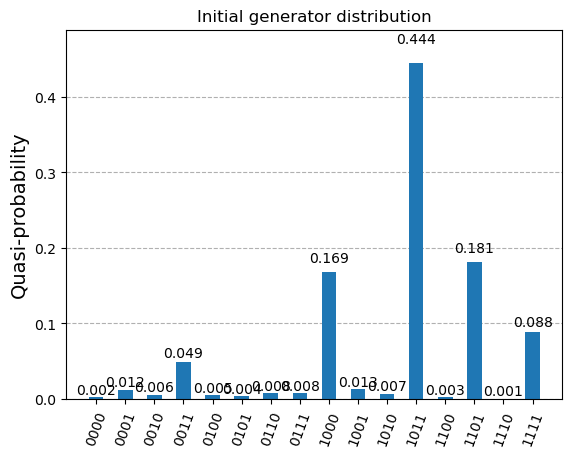

In [426]:
# Display initial generator distribution
init_gen_circuit = generator.assign_parameters(init_gen_params)
init_prob_dict = Statevector(init_gen_circuit).probabilities_dict()

fig, ax1 = plt.subplots(1, 1, sharey=True)
ax1.set_title("Initial generator distribution")
plot_histogram(init_prob_dict, ax=ax1)

In [427]:
# Initialize Adam optimizer from Keras (TensorFlow)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)

In [429]:
# Training
training_data_file = 'data/training_data.txt'
parameter_data_file = 'data/parameters.txt'
max_epoch = 300

conti = 1 # Continue training from last execution
if conti == 1:
    with open(training_data_file) as f:
        lines = f.read().splitlines()
    current_epoch = len(lines)
    gloss, dloss, kl_div = [], [], []
    for line in lines: # Just or graph
        line_data = line.split(";")
        if len(line_data) != 4:
            print("Error in training_data.txt file in line:", line)
        gloss.append(np.float64(line_data[1]))
        dloss.append(np.float64(line_data[2]))
        kl_div.append(np.float64(line_data[3]))

    with open(parameter_data_file) as f:
        line = f.readline()
    line_data = line.split(";")
    if len(line_data) != 3:
        print("Error in parameters.txt file")
    gen_params = tf.Variable(np.array(eval(line_data[0])).astype(float))
    disc_params = tf.Variable(np.array(eval(line_data[1])).astype(float))
    best_gen_params = tf.Variable(np.array(eval(line_data[2])).astype(float))

    file = open(training_data_file,'a')

else:
    current_epoch = 0
    gloss, dloss, kl_div = [], [], []
    gen_params = tf.Variable(init_gen_params)
    disc_params = tf.Variable(init_disc_params)
    best_gen_params = tf.Variable(init_gen_params)
    file = open(training_data_file,'w')

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
    
TABLE_HEADERS = "Epoch | Generator cost | Discriminator cost | KL Div. | Best KL Div. | Time |"
print(TABLE_HEADERS)
start_time = time.time()

try: # In case of interruption
    for epoch in range(current_epoch, max_epoch):

        #--- Quantum discriminator parameter updates ---#
        D_STEPS = 5 # N discriminator updates per generator update
        for disc_train_step in range(D_STEPS):
            d_fake = disc_fake_qnn.backward(gen_params, disc_params)[1].todense()[0, 2**(REAL_DIST_NQUBITS-1):] #Backwards returns [n_batch, n_qubits, n_params] shape
            d_fake = np.sum(d_fake, axis=0) # sum of all [n_params] shape gradient for each possible output where last qubit is 1

            d_real = disc_real_qnn.backward([], disc_params)[1].todense()[0, 2**(REAL_DIST_NQUBITS-1):]
            d_real = np.sum(d_real, axis=0)

            grad_dcost = [d_fake[i] - d_real[i] for i in range(N_DPARAMS)]
            grad_dcost = tf.convert_to_tensor(grad_dcost)
            
            discriminator_optimizer.apply_gradients(zip([grad_dcost],
                                                        [disc_params]))
            
            if disc_train_step % D_STEPS == 0:
                dloss.append(discriminator_cost(disc_params))

        #--- Quantum generator parameter updates ---#
        for gen_train_step in range(1):
            grads = gen_qnn.backward(disc_params, gen_params)
            grads = grads[1].todense()[0][2**(REAL_DIST_NQUBITS-1):]

            grads = -np.sum(grads, axis=0)
            grads = tf.convert_to_tensor(grads)

            generator_optimizer.apply_gradients(zip([grads], [gen_params]))
            gloss.append(generator_cost(gen_params))

        #--- Track KL and save best performing generator weights ---#
        # Create test circuit with updated gen parameters
        gen_checkpoint_circuit = generator.assign_parameters(gen_params.numpy())

        # Retrieve probability distribution of current generator
        gen_prob_dict = Statevector(gen_checkpoint_circuit
                                ).probabilities_dict()
        
        # Constant real probability distribution
        real_prob_dict = Statevector(real_circuit).probabilities_dict()
        
        current_kl = calculate_kl_div(gen_prob_dict, real_prob_dict)
        kl_div.append(current_kl)
        if np.min(kl_div) == current_kl:
            # New best
            # serialize & deserialize to simply ensure zero links
            best_gen_params = copy.deepcopy(gen_params)

        # Save progress in file
        file.write(str(epoch) + ";" + str(gloss[-1]) + ";" + str(dloss[-1]) + ";" + str(kl_div[-1]) + "\n")

        # Print progress
        if epoch % 10 == 0:
            for header, val in zip(TABLE_HEADERS.split('|'),
                                (epoch, gloss[-1], dloss[-1], kl_div[-1], np.min(kl_div), (time.time() - start_time))):
                print(f"{val:.3g} ".rjust(len(header)), end="|")
            start_time = time.time()
            print()
finally:
    file.close()
    file = open(parameter_data_file,'w')
    file.write(str(gen_params.numpy().tolist()) + ";" + str(disc_params.numpy().tolist()) + ";" + str(best_gen_params.numpy().tolist()) + "\n")
    file.close()


Epoch | Generator cost | Discriminator cost | KL Div. | Best KL Div. | Time |
  180 |         -0.173 |             -0.389 |   0.446 |        0.446 | 15.6 |
  190 |         -0.317 |             -0.265 |   0.484 |        0.443 | 15.2 |
  200 |         -0.387 |             -0.334 |   0.379 |        0.379 | 15.7 |
  210 |         -0.597 |            -0.0591 |   0.392 |        0.352 | 15.4 |
  220 |         -0.401 |             -0.275 |   0.388 |        0.352 | 15.9 |
  230 |         -0.598 |             -0.123 |   0.342 |        0.342 | 15.1 |
  240 |         -0.533 |            -0.0266 |   0.379 |        0.341 | 15.5 |
  250 |         -0.645 |             -0.268 |   0.249 |        0.249 | 15.3 |
  260 |          -0.68 |             -0.122 |   0.133 |        0.133 | 15.5 |
  270 |         -0.432 |             -0.139 |   0.173 |        0.133 | 15.1 |
  280 |         -0.608 |             -0.141 |  0.0673 |       0.0673 | 14.6 |
  290 |         -0.567 |            -0.0433 |   0.109 |       0.

[np.float64(2.679809597136797), np.float64(2.7360372928626395), np.float64(2.779643270986944), np.float64(2.834783954771405), np.float64(2.8801781736591665), np.float64(2.9136070539271213), np.float64(2.952628647692468), np.float64(2.9960268677564694), np.float64(3.036179691032333), np.float64(3.0892069156841404), np.float64(3.160931103111877), np.float64(3.301422072465053), np.float64(3.472964827606649), np.float64(3.6386638701823344), np.float64(3.7366967360387604), np.float64(3.803010589596133), np.float64(3.877959410516125), np.float64(3.9605332963145505), np.float64(4.051281899768949), np.float64(4.154618366058732), np.float64(4.267582392624702), np.float64(4.472426525017706), np.float64(4.397482904190991), np.float64(4.303766700571287), np.float64(4.222245577263325), np.float64(4.133801879377991), np.float64(4.027638142741247), np.float64(3.9174627483164093), np.float64(3.8003055208454453), np.float64(3.662959084803995), np.float64(4.56037235566403), np.float64(5.298706667356048)

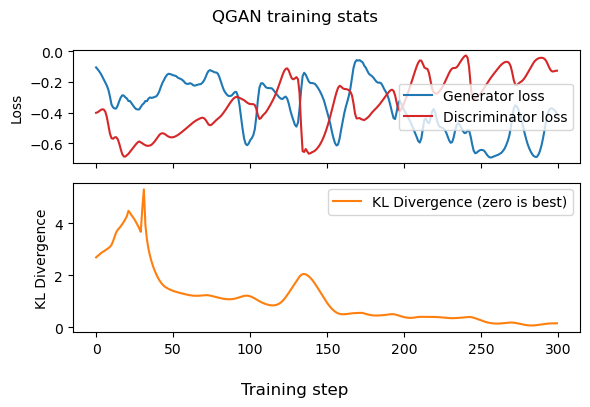

In [430]:
fig, (loss, kl) = plt.subplots(2, sharex=True,
                               gridspec_kw={'height_ratios': [0.75, 1]},
                               figsize=(6,4))
fig.suptitle('QGAN training stats')
fig.supxlabel('Training step')
loss.plot(range(len(gloss)), gloss, label="Generator loss")
loss.plot(range(len(dloss)), dloss, label="Discriminator loss",
          color="C3")
loss.legend()
loss.set(ylabel='Loss')
kl.plot(range(len(kl_div)), kl_div, label="KL Divergence (zero is best)", #AÑADIR LINEA PUNTITOS PA CURRENT MIN KL
        color="C1")
kl.set(ylabel='KL Divergence')
kl.legend()
fig.tight_layout();
print(kl_div)

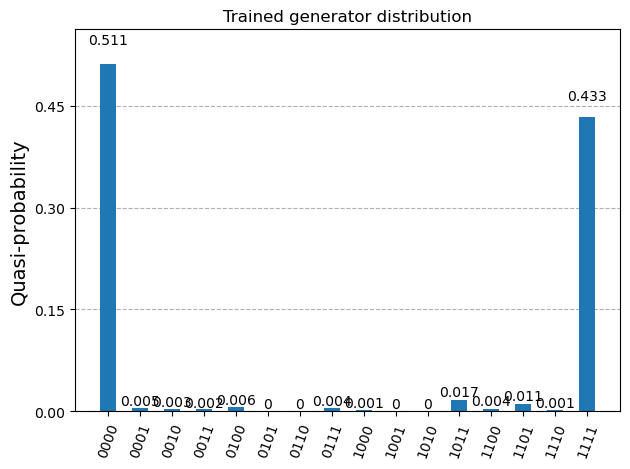

In [431]:
# Create test circuit with new parameters
gen_checkpoint_circuit = generator.assign_parameters(best_gen_params.numpy())
gen_prob_dict = Statevector(gen_checkpoint_circuit).probabilities_dict()
real_prob_dict = Statevector(real_circuit).probabilities_dict() # constant
#fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(9,3))
fig, ax1 = plt.subplots(1, 1, sharey=True)
plot_histogram(gen_prob_dict, ax=ax1)
ax1.set_title("Trained generator distribution")
#plot_histogram(real_prob_dict, ax=ax2)
#ax2.set_title("Real distribution")
fig.tight_layout()

In [ ]:
#from qiskit.opflow import (StateFn, PauliSumOp, Gradient, AerPauliExpectation)
#from qiskit_machine_learning.neural_networks import OpflowQNN

from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import Estimator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient

# Estimator backend (Aer statevector)
estimator = Estimator()
gradient = ParamShiftEstimatorGradient(estimator)

backend = Aer.get_backend('aer_simulator_statevector')


In [ ]:
#from qiskit.primitives import StatevectorEstimator
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient


estimator = Estimator()
gradient = ParamShiftEstimatorGradient(estimator)
H1 = SparsePauliOp.from_list([("I"*(REAL_DIST_NQUBITS-1)+"Z", 1.0)])
disc_params = list(gen_disc_circuit.parameters)[:N_DPARAMS]
gen_params = list(gen_disc_circuit.parameters)[N_DPARAMS:]

# construct OpflowQNN with the two operators, the input parameters,
# the weight parameters, the expected value, and quantum instance.
# |fake> => |0> => 1 ; |real> => |1> => -1
gen_opqnn = EstimatorQNN(circuit=gen_disc_circuit,
                      observables=[H1],
                      # input parameters (discriminator weights)
                      input_params=disc_params,
                      # differentiable weights (generator weights)
                      weight_params=gen_params,
                      estimator=estimator,
                      gradient=gradient
                      )
disc_fake_opqnn = EstimatorQNN(circuit=gen_disc_circuit,
                            observables=[H1],
                            # input parameters (generator weights)
                            input_params=gen_params,
                            # differentiable weights (discrim. weights)
                            weight_params=disc_params,
                            estimator=estimator,
                            gradient=gradient
                            )
disc_real_opqnn = EstimatorQNN(circuit=real_disc_circuit,
                            observables=[H1],
                            input_params=[],
                            # differentiable weights (discrim. weights)
                            weight_params=disc_params,
                            estimator=estimator,
                            gradient=gradient
                            )

/tmp/ipykernel_3961/2251266090.py:8: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
/tmp/ipykernel_3961/2251266090.py:17: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  gen_opqnn = EstimatorQNN(circuit=gen_disc_circuit,
/tmp/ipykernel_3961/2251266090.py:26: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  disc_fake_opqnn = Estimator

In [ ]:
best_gen_params = init_gen_params
gloss, dloss, kl_div = [], [], []
TABLE_HEADERS = "Epoch | Gen. cost | Discrim. cost | KL Div | New best? |"
print(TABLE_HEADERS)
for epoch in range(1200):
    D_STEPS = 1
    #--- Quantum discriminator parameter update ---#
    for disc_train_step in range(D_STEPS):
        grad_dcost_fake = disc_fake_opqnn.backward(gen_params,
                                                   disc_params)[1][0,0]
        grad_dcost_real = disc_real_opqnn.backward([],
                                                   disc_params)[1][0,0]
        grad_dcost = grad_dcost_real - grad_dcost_fake # as above
        grad_dcost = tf.convert_to_tensor(grad_dcost)
        # update disc_params
        discriminator_optimizer.apply_gradients(zip([grad_dcost],
                                                    [disc_params]))
        if disc_train_step % D_STEPS == 0:
            dloss.append(discriminator_cost(disc_params))

    #--- Quantum generator parameter update ---#
    for gen_train_step in range(1):
        # as formulated above
        grad_gcost = gen_opqnn.backward(disc_params,
                                        gen_params)[1][0,0]
        grad_gcost = tf.convert_to_tensor(grad_gcost)
        # update gen_params
        generator_optimizer.apply_gradients(zip([grad_gcost],
                                                [gen_params]))
        gloss.append(generator_cost(gen_params))

    #--- Track KL and save best performing generator weights ---#
    # Create test circuit with updated gen parameters
    gen_checkpoint_circuit = generator.assign_parameters(gen_params.numpy())
    # Retrieve probability distribution of current generator
    gen_prob_dict = Statevector(gen_checkpoint_circuit
                               ).probabilities_dict()
    # Constant real probability distribution
    real_prob_dict = Statevector(real_circuit).probabilities_dict()
    current_kl = calculate_kl_div(gen_prob_dict, real_prob_dict)
    kl_div.append(current_kl)
    new_best = (np.min(kl_div) == current_kl)
    if new_best:
        # Store new best generator weights
        # serialize & deserialize to just zero links
        best_gen_params = pickle.loads(pickle.dumps(gen_params))
    if epoch % 30 == 0:
        # print table
        for header, val in zip(TABLE_HEADERS.split('|'),
                              (epoch, gloss[-1], dloss[-1],
                               kl_div[-1], new_best)):
            print(f"{val:.3g} ".rjust(len(header)), end="|")
        print()

Epoch | Gen. cost | Discrim. cost | KL Div | New best? |


QiskitMachineLearningError: "Estimator job failed. 'Expression cannot bind non-numeric values ({ParameterVectorElement(inputs[0]): ParameterVectorElement(θ_g[0])})'"